<a href="https://colab.research.google.com/github/villifCoder559/VGGFaceFeatures_PCA/blob/main/VGGFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -Uqq ipdb
import ipdb

In [2]:
%%capture
!pip install faiss-cpu --no-cache

In [3]:
%%capture
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install tensorflow keras_applications
!pip install layer_utils

In [4]:
%%capture
!pip install keras==2.12

In [5]:
import numpy as np
import pandas as pd
import cv2
import keras
from keras_vggface.vggface import VGGFace
from sklearn.datasets import fetch_lfw_people
from skimage.transform import resize
import faiss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import tensorflow as tf

<h1>Balancing Dataset

In [6]:
def init_balanced_dataset(lfw_people,balanced_dataset=True):
  np.random.seed(42)
  data=lfw_people.images
  target=lfw_people.target
  index_list,nr_elements_per_class=np.unique(target,return_counts=True)
  min_elements=min(nr_elements_per_class)
  balanced_data=[]
  balanced_target=[]
  if balanced_dataset:
    for s_class in index_list:
      list_indices = np.argwhere(target == s_class).reshape(-1)
      choices = np.random.choice(list_indices, min_elements, replace = False)
      balanced_target.append(np.full(min_elements,s_class))
      balanced_data.append(data[choices])
    balanced_data=np.array(balanced_data)
    balanced_target=np.array(balanced_target)
    balanced_data=balanced_data.reshape(balanced_data.shape[0]*balanced_data.shape[1],balanced_data.shape[2],balanced_data.shape[3],balanced_data.shape[4])
    balanced_target=balanced_target.reshape(-1)
    print('balancedData',balanced_data.shape)
    print('balancedTarget',balanced_target.shape)
    print()
  else:
    balanced_data=data
    balanced_target=target
    print('balancedData',balanced_data.shape)
    print('balancedTarget',balanced_target.shape)
  return balanced_data,balanced_target

<h1>Image normalization and standardization and Extract features</h1>

In [7]:
from sklearn.model_selection import train_test_split
from google.colab import drive
import os

def compute_features(balanced_data,balanced_target,use_VGGface=True,random_state=2,std_dataset=True):
  X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_target, test_size=0.2, random_state=random_state)

  image_samples_train=np.copy(X_train)
  if std_dataset:
    image_samples_train=np.array([cv2.resize(img,(224,224)) for img in image_samples_train])
    image_samples_train[:,:,:,0]=(image_samples_train[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
    image_samples_train[:,:,:,1]=(image_samples_train[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
    image_samples_train[:,:,:,2]=(image_samples_train[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))

  image_samples_test=np.copy(X_test)
  if(std_dataset):
    image_samples_test=np.array([cv2.resize(img,(224,224)) for img in image_samples_test])
    image_samples_test[:,:,:,0]=(image_samples_test[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
    image_samples_test[:,:,:,1]=(image_samples_test[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
    image_samples_test[:,:,:,2]=(image_samples_test[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))
  if use_VGGface:
    if tf.config.list_physical_devices('GPU'):
      vggface = VGGFace(model='vgg16',include_top=False,input_shape=(image_samples_train.shape[1],image_samples_train.shape[2],image_samples_train.shape[3]))
      result_train=vggface.predict(image_samples_train)
      result_test=vggface.predict(image_samples_test)
      print('GPU available')
    else:
      drive.mount('/content/drive')
      drive_path = '/content/drive/MyDrive/'
      result_train=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'),allow_pickle=True)
      result_test=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'),allow_pickle=True)
      print('GPU not available. Getting features from local BALANCED dataset (train_test_split with random_state=2)...')
  else:
    result_train=image_samples_train
    result_test=image_samples_test
  return result_train,result_test,y_test,y_train

<h1>Save/load features from drive

In [8]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# drive_path = '/content/drive/MyDrive/'
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'), original_result_train)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'), original_result_test)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_train.npy'), original_result_train)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_test.npy'), original_result_test)

In [9]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# drive_path = '/content/drive/MyDrive/'
# result_train_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'),allow_pickle=True)
# result_test_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'),allow_pickle=True)
# result_train_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_train.npy'),allow_pickle=True)
# result_test_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_test.npy'),allow_pickle=True)

In [30]:
#create reduction (if n_components is negative it means to remove the first n_components instead of lasts)
def create_test_reduction(n_components,result_train,type_index='FlatL2',fixed_components=30):
  if type_index not in ['FlatL2', 'FlatIP']:
        raise ValueError("Type must be 'FlatL2' or 'FlatIP'")
  features_reducted=result_train.reshape(result_train.shape[0],-1)
  if n_components > 0:
    tmp_PCA=PCA(n_components=n_components)
    features_reducted=np.ascontiguousarray(tmp_PCA.fit_transform(features_reducted))
  else:
    tmp_PCA=PCA(n_components=fixed_components).fit(features_reducted)
    features_reducted=custom_reduction(tmp_PCA,result_train,n_components)
  faiss.normalize_L2(features_reducted)
#   # Get explained variance
#   explained_variance_ratio = tmp_PCA.explained_variance_ratio_

#   # Calculate cumulative explained variance
#   cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

#   # Individual explained variance plot
#   plt.figure(figsize=(8, 6))
#   plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
#   plt.xlabel('Principal Component')
#   plt.ylabel('Explained Variance Ratio')
#   plt.title('Individual Explained Variance per Component')

#   # Add vertical lines at specific points
#   plt.axvline(x=20, color='r', linestyle='--', label='X=20')
#   plt.axvline(x=50, color='g', linestyle='--', label='X=50')
#   plt.axvline(x=100, color='b', linestyle='--', label='X=100')
#   plt.axvline(x=396, color='k', linestyle='--', label='X=396')  # Assuming the maximum component is 396
#   plt.legend()

#   # Cumulative explained variance plot
#   plt.figure(figsize=(8, 6))
#   plt.plot(range(len(cumulative_explained_variance_ratio)), cumulative_explained_variance_ratio,
#             marker='o', linestyle='--')
#   plt.xlabel('Principal Component')
#   plt.ylabel('Cumulative Explained Variance Ratio')
#   plt.title('Cumulative Explained Variance')

#   # Add vertical lines at specific points (optional, adjust for cumulative plot if needed)
#   plt.axvline(x=20, color='r', linestyle='--', label='X=20')
#   plt.axvline(x=50, color='g', linestyle='--', label='X=50')
#   plt.axvline(x=100, color='b', linestyle='--', label='X=100')
#   plt.axvline(x=396, color='k', linestyle='--', label='X=396')
#   plt.legend()
#   plt.show()
  if type_index=='FlatIP':
    return tmp_PCA,features_reducted,faiss.IndexFlatIP(features_reducted.shape[1])
  else:
    return tmp_PCA,features_reducted,faiss.IndexFlatL2(features_reducted.shape[1])

In [11]:
def custom_reduction(pca,result_train,start_index):
  transformed_results = []
  for element in result_train:
    test = element.reshape(1, -1)
    # Apply PCA transformation
    transformed_result = np.dot(test - pca.mean_, pca.components_[(-start_index):].T)
    transformed_results.append(transformed_result)
  return np.array(transformed_results).reshape(result_train.shape[0],pca.components_.shape[0]+start_index)

<h1>Create Tests

In [12]:
def create_test(list_n_components,fixed_components,result_train_vgg):
  index_type='FlatIP' # FlatIP or FlatL2
  print('Fixed_components=',fixed_components)
  pca_objs=[]
  features_objs=[]
  index_faiss_objs=[]
  for n_components in list_n_components:
    if n_components>0:
      pca,features,index=create_test_reduction(n_components,result_train_vgg,index_type)
      pca_objs.append(pca)
      features_objs.append(features)
      index_faiss_objs.append(index)
    else:
      if(n_components<0):
        pca,features,index=create_test_reduction(n_components,result_train_vgg,index_type,fixed_components)
        pca_objs.append(pca)
        features_objs.append(features)
        index_faiss_objs.append(index)
      else: # dummy PCA
        pca_objs.append(PCA())
        res_train_norm=np.copy(result_train_vgg.reshape(result_train_vgg.shape[0],-1))
        faiss.normalize_L2(res_train_norm)
        features_objs.append(res_train_norm)
        if index_type=='FlatIP':
          index_faiss_objs.append(faiss.IndexFlatIP(res_train_norm.shape[1]))
        else:
          index_faiss_objs.append(faiss.IndexFlatL2(res_train_norm.shape[1]))
  #add vectors to index
  count=0
  for index in index_faiss_objs:
    # print(features_objs[count].shape)
    index.add(features_objs[count])
    count=count+1
  return pca_objs,features_objs,index_faiss_objs

In [13]:
def compute_precision_recall(ground_truth,target,index,top_k,reduced_vector,train_elements_nr):
  TP=-1
  reduced_vector=np.ascontiguousarray(reduced_vector.reshape(1, -1))
  # print(reduced_vector.shape)
  _,retrived_elements=index.search(reduced_vector, train_elements_nr)
  retrived_targets_id=ground_truth[retrived_elements]==target
  # print(retrived_elements)
  indices = np.where(retrived_targets_id.reshape(-1))[0]
  if(top_k>len(indices)):
    # print('Face nr.',target,'max elements:',len(indices)-1,'(NOT',str(top_k)+')')
    top_k=len(indices)
  stop=indices[top_k-1]+1
  TP=top_k
  total_samples=np.sum(ground_truth==target)
  FP=stop-TP
  FN=total_samples-TP
  precision=0
  if TP+FP!=0:
    precision=TP/(TP+FP)
  recall=TP/((TP+FN))
  return precision,recall

In [14]:
def predict(ground_truth_train,ground_truth_test,index_faiss_objs,test_vectors,list_n_components,train_elements_nr=9):
  i=0
  j=0
  test_vectors=test_vectors.reshape(test_vectors.shape[0],-1)
  nr_labels=np.unique(y_train).shape[0]
  result=[]
  list_results=[]

  for index in index_faiss_objs:
      # start=time.time()
      for vector in test_vectors:
        # print(list_n_components[i])
        if list_n_components[i] > 0:
          reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_.T
        else:
          if list_n_components[i] < 0:
            reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_[-list_n_components[i]:].T
          else:
            reduced_vector=vector
            reduced_vector=np.reshape(reduced_vector,(1,reduced_vector.shape[0]))
        reduced_vector=reduced_vector/np.linalg.norm(reduced_vector)
        # ipdb.set_trace()
        distances,retrived_elements=index.search(reduced_vector, train_elements_nr)
        sum_per_class=[np.sum(ground_truth_train[retrived_elements]==i) for i in range(nr_labels)]
        max_indices = np.where(sum_per_class == np.max(sum_per_class))[0]
        if len(max_indices) > 1:  # If multiple classes have the same sum
          index_vct=[(ground_truth_train[retrived_elements]==i) for i in (max_indices)]
          dist=[np.sum(distances[vector]) for vector in index_vct]
          # if(index.__class__.__name__ == 'IndexFlatIP'): USE IN CASE VECTORS AREN'T NORMALIZED -> L2_dist != IP_dist
          max_index=np.argmax(dist)
          best=max_indices[max_index]
          # else:
          #   min_index=np.argmin(dist)
          #   best=max_indices[min_index]
          # ipdb.set_trace()
        else:
          best = max_indices[0]
        result.append(best)
        j+=1
      j=0
      i=i+1
      result=np.array(result)
      accuracy=np.sum(result==ground_truth_test)/result.shape[0]
      list_results.append(accuracy)
      result=[]
  return list_results

<h1>Compute Precision-recall

In [15]:
import time
def compute_all_precision_recall(list_top_elements,list_n_components,index_faiss_objs,pca_objs,y_train,y_test,result_test_vgg,result_train):
  # list_top_elements=[5,10,20,100]
  i=0
  j=0
  k=0
  precision_results=[]
  recall_results=[]
  name_results=[]
  list_precision_results=[]
  list_recall_results=[]
  # reduced_vector_list=[]
  test_vectors=result_test_vgg.reshape(result_test_vgg.shape[0],-1)
  for top_k in list_top_elements:
    for index in index_faiss_objs:
      # start=time.time()
      for vector in test_vectors:
        if list_n_components[i] > 0:
          reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_.T
        else:
          if list_n_components[i] < 0:
            reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_[-list_n_components[i]:].T
          else:
            reduced_vector=np.array(vector)
        reduced_vector=reduced_vector/np.linalg.norm(reduced_vector)
        # reduced_vector_list.append(reduced_vector)
        # predict(y_train,index,reduced_vector,9)
        precision,recall=compute_precision_recall(y_train,y_test[j],index,top_k,reduced_vector,result_train.shape[0])
        name_results.append(y_test[j])
        precision_results.append(precision)
        recall_results.append(recall)
        j=j+1
      j=0
      i=i+1
    i=0
      # tmp=time.time()-start
  recall_results=np.array(recall_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
  precision_results=np.array(precision_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
  name_results=np.array(name_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
  return recall_results,precision_results,name_results

In [16]:
def create_DataFrame(id_labels,selected_name_result,selected_precision_result,selected_recall_result,normalization_factors,index_faiss_n_components,list_n_components,index_selected_top_k_retrival):
  str_top_k=str(list_top_elements[index_selected_top_k_retrival])
  text=''
  index_type=''
  precision_vector=np.bincount(selected_name_result,weights=selected_precision_result)/normalization_factors
  recall_vector=np.bincount(selected_name_result,weights=selected_recall_result)/normalization_factors
  # F1_vector=2*(precision_vector*recall_vector)/(precision_vector+recall_vector)
  if index_faiss_objs[index_faiss_n_components].__class__.__name__ == 'IndexFlatIP':
    index_type='(IP)'
  else:
    index_type='(L2)'
  if list_n_components[index_faiss_n_components]<0:
    text='/'+str(fixed_components)
  df = pd.DataFrame({
    "Faces":id_labels,
    # ("F"+index_type+"@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])+text):F1_vector        # F1
    ("P"+index_type+"@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])+text):precision_vector,  # Precision
    # ("R@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])):recall_vector,                      # Recall
  })
  # Calculate the averages of each column
  avg_row = df.mean(axis=0)
  avg_row["Faces"] = "Average"
  # Append the average row to the DataFrame
  # df = pd.concat([df,avg_row],ignore_index=True)
  df = df.append(avg_row, ignore_index=True)
  return df

In [17]:
def create_list_dataframe(precision_results,name_results,recall_results,list_n_components,y_test,list_top_elements):
  df_list=[]
  # avg_precision=[]
  for i in range(precision_results.shape[0]):
    for j in range(precision_results.shape[1]):
      selected_name_result = name_results[i][j]
      selected_recall_result = recall_results[i][j]
      selected_precision_result = precision_results[i][j]
      # avg_precision.append(np.mean(selected_precision_result))
      id_labels,normalization_factors = np.unique(y_test,return_counts=True)
      df=create_DataFrame(id_labels,selected_name_result,selected_precision_result,selected_recall_result,normalization_factors,j,list_n_components,i)
      df_list.append(df)
  # avg_precision=np.array(avg_precision).reshape(len(list_top_elements),len(list_n_components))
  return df_list

F1 Score all retrived<br>
P(IP)@1000_0    -> F-Score(distance_InnerProduct)@all_elements_noPCAReduction<br>
P(IP)@1000_200  ->F-Score(distance_InnerProduct)@all_elements_PCA_200_Components<br>
P(IP)@1000_-2/25-> F-Score(Distance_InnerProduct)@W/h first 2 componets out of 25

In [18]:
def merge_dataframe(list_top_elements,df_list,drop_faces_col=True):
  merged_df_list=[]
  count=0
  for pick_top_k in list_top_elements:
    merged_df=df_list[count]
    for i in range(count+1,count+int(len(df_list)/len(list_top_elements))):
      merged_df=pd.merge(merged_df,df_list[i])
    if drop_faces_col:
      merged_df_list.append(merged_df.drop(columns=['Faces']).style.highlight_min(color = 'red', axis = 1).highlight_max(color = 'green', axis = 1))
    else:
      merged_df_list.append(merged_df)
    count+=int(len(df_list)/len(list_top_elements))
  return merged_df_list

In [19]:
def compute_fisher(pca_objs,list_n_components,result_train,result_test,y_train):
  accuracy_results=[]
  count=0
  # for n_components in list_n_components:
  for pca in pca_objs:
    print('PCA components',list_n_components[count])
    eigenface_recognizer = cv2.face.EigenFaceRecognizer_create()
    if list_n_components[count]>0:
      train=pca.fit_transform(result_train.reshape(result_train.shape[0],-1))
    else:
      train=result_train.reshape(result_train.shape[0],-1)
    eigenface_recognizer.train(train, np.array(y_train))
    correct = 0
    if list_n_components[count]>0:
      test=pca.transform(result_test.reshape(result_test.shape[0],-1))
    else:
      test=result_test.reshape(result_test.shape[0],-1)
    total = len(test)
    for i in range(total):
        label, confidence = eigenface_recognizer.predict(test[i])
        if label == y_test[i]:
            correct += 1
    accuracy = correct / total
    accuracy_results.append(accuracy)
    # print(f"Accuracy: {accuracy}%")
    # print()
  return np.array(accuracy_results).reshape(-1)

In [20]:
lfw_people = fetch_lfw_people(min_faces_per_person=55, resize=2.4,color=True)

In [ ]:
len(lfw_people.target_names)

9

balancedData (1403, 300, 225, 3)
balancedTarget (1403,)
9/9 [==============================] - 1s 120ms/step
GPU available
Fixed_components= 20


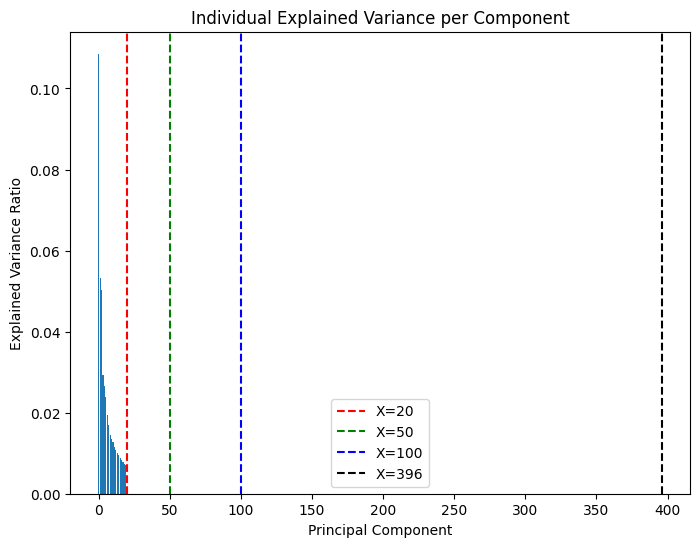

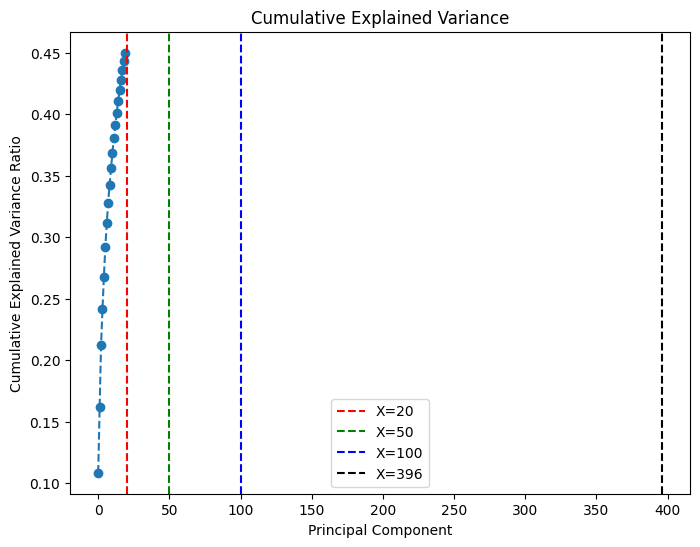

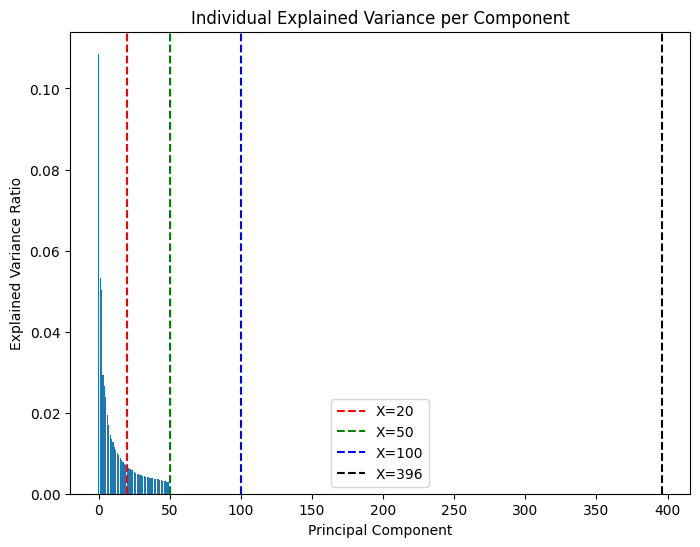

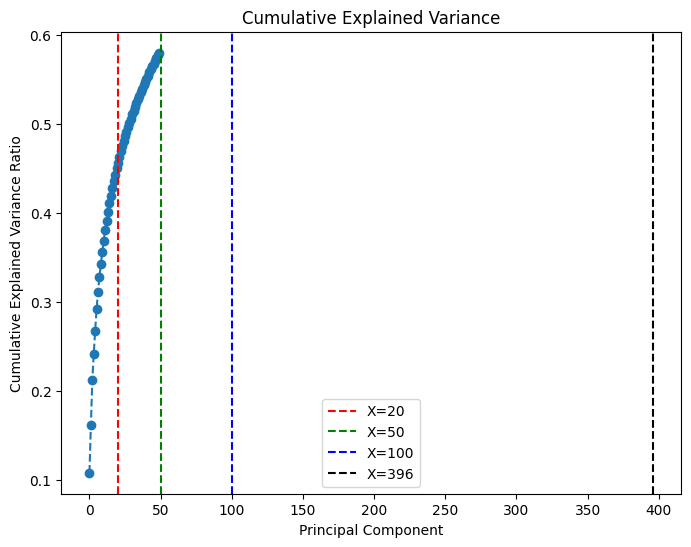

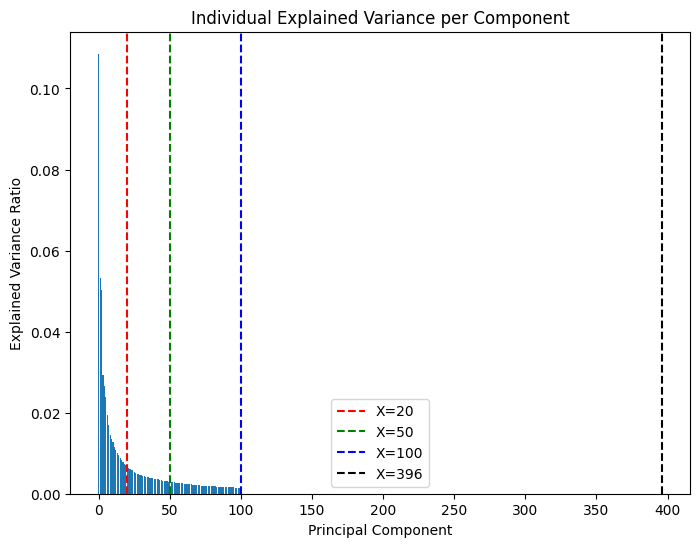

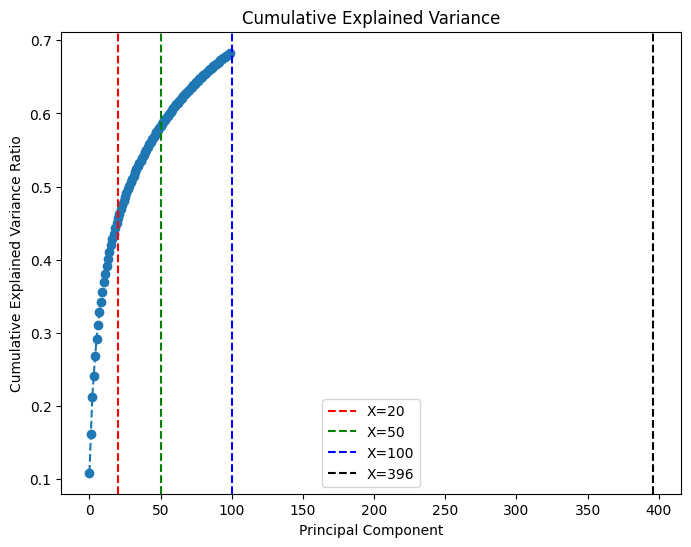

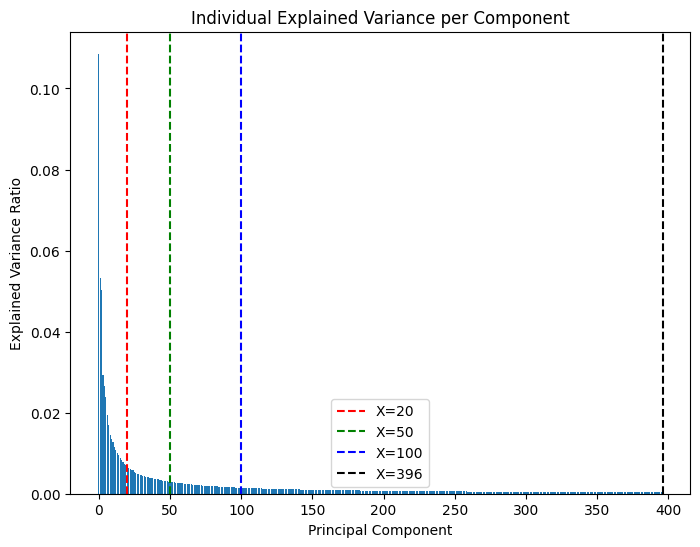

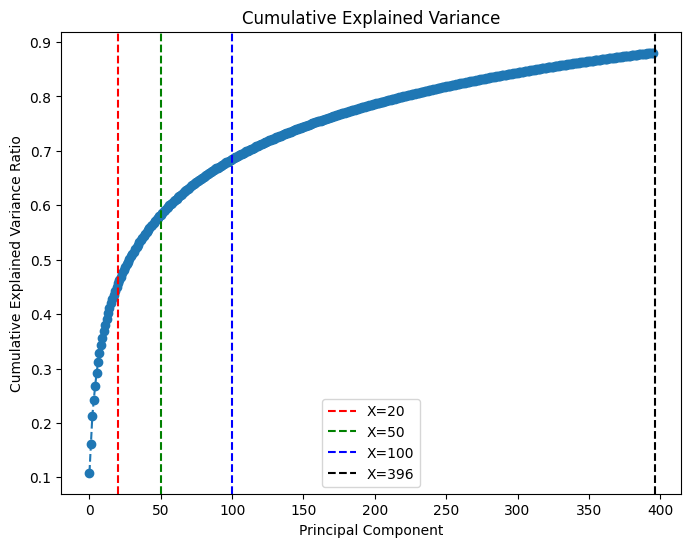

random_state 2 time -> -36.001397132873535


In [31]:
import time
list_top_elements = [5]
list_n_components =[0,20,50,100,396] # 0 -> No PCA reduction
fixed_components_list = [20]
random_state_list=[2] #range(1,10)
predictions_vgg=[]
predictions_fisher=[]
list_precision_results=[]
make_prediction=True
balanced_data,balanced_target=init_balanced_dataset(lfw_people,balanced_dataset=False)
for random_state in random_state_list:
  start=time.time()
  for fixed_components in fixed_components_list:
    result_train,result_test,y_test,y_train=compute_features(balanced_data,balanced_target,use_VGGface=True,random_state=random_state,std_dataset=True)
    pca_objs, features_objs, index_faiss_objs = create_test(list_n_components,fixed_components,result_train)
    if make_prediction:
      predictions_vgg.append(predict(y_train,y_test,index_faiss_objs,result_test,list_n_components))
      # predictions_fisher.append(compute_fisher(pca_objs,list_n_components,result_train,result_test,y_train))
    else:
      recall_results, precision_results, name_results = compute_all_precision_recall(list_top_elements,list_n_components,index_faiss_objs,pca_objs,y_train,y_test,result_test,result_train)
      df_list=create_list_dataframe(precision_results,name_results,recall_results,list_n_components,y_test,list_top_elements)
      merged_df_list=merge_dataframe(list_top_elements,df_list,drop_faces_col=False)
      list_precision_results.append(merged_df_list)
  print('random_state '+str(random_state)+' time -> '+str(start-time.time()))
if make_prediction:
  predictions_vgg=np.array(predictions_vgg)
list_precision_results = np.array(list_precision_results)

In [ ]:
mean=np.mean(np.array(list_precision_results)[:,:,:,1:],axis=(0))
t=np.array(list_precision_results)[:,:,:,1:].astype(np.float64)
std=np.std(t,axis=(0))
obj={}
for i in range(len(list_top_elements)):
  # obj['mean_top_'+str(list_top_elements[i])]=[]
  # obj['std_top_'+str(list_top_elements[i])]=[]
  for j in range(len(list_n_components)):
    key_mean = 'mean_top_' + str(list_top_elements[i]) + '|cmp_' + str(list_n_components[j])
    key_std = 'std_top_' + str(list_top_elements[i]) + '|cmp_' + str(list_n_components[j])
    if not isinstance(obj.get(key_mean), list):
        obj[key_mean] = []
    obj[key_mean].append(mean[i,:,j])
    if not isinstance(obj.get(key_std), list):
        obj[key_std] = []
    obj[key_std].append(std[i,:,j])

In [ ]:
## Test if it works with len(fixed_components_list)=1
#NEGATIVE elements with len(fixed_component_list)>1
tst=np.array(list_precision_results).reshape(len(random_state_list),len(fixed_components_list),len(list_top_elements),10,-1)
mean=np.mean(tst[:,:,:,:,1:],axis=(0))
t=tst[:,:,:,:,1:].astype(np.float64)
std=np.std(t,axis=(0))
obj={}
for i in range(len(fixed_components_list)):
  # obj['mean_top_'+str(list_top_elements[i])]=[]
  # obj['std_top_'+str(list_top_elements[i])]=[]
  for j in range(len(list_top_elements)):
    for k in range(len(list_n_components)):
      key_mean = 'mean_top_' + str(list_top_elements[j]) + '|cmp_' + str(list_n_components[k])+'/'+str(fixed_components_list[i])
      key_std = 'std_top_' + str(list_top_elements[j]) + '|cmp_' + str(list_n_components[k])+'/'+str(fixed_components_list[i])
      if not isinstance(obj.get(key_mean), list):
          obj[key_mean] = []
      obj[key_mean].append(mean[i,j,:,k])
      if not isinstance(obj.get(key_std), list):
          obj[key_std] = []
      obj[key_std].append(std[i,j,:,k])

In [ ]:
from google.colab import drive
import os
import pickle
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
# Serialize and save the object to a file
with open('/content/drive/My Drive/obj_no_std_negative.pkl', 'wb') as f:
    pickle.dump(obj, f)

In [ ]:
from google.colab import drive
import os
import pickle
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
with open('/content/drive/My Drive/obj_no_std_negative.pkl', 'rb') as f:
    obj_no_std = pickle.load(f)
with open('/content/drive/My Drive/obj_std_negative.pkl', 'rb') as f:
    obj_std = pickle.load(f)

In [ ]:
merged_df_list[1]

In [ ]:
merged_df_list[2]

In [ ]:
merged_df_list[3]